In [106]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import warnings
import time

np.set_printoptions(linewidth=200, suppress=True, precision=3)

# Функции и классы

In [50]:
def plot_class_distribution(classes):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    sns.countplot(x = classes)
    plt.title('Распределение классов')
    plt.xlabel('Цифры')
    plt.show()

    # Reset the warning filter to its default state
    warnings.filterwarnings("default")

def reduce_dataset(X, y, reduce_to):
    # Создать пустые списки для хранения индексов
    idx = []

    # Для каждого класса от 0 до 9
    for i in range(10):
        # Найти индексы примеров, соответствующих данному классу
        idx_i = np.where(y == i)[0]
        # Случайным образом выбрать подмножество индексов
        idx_i = np.random.choice(idx_i, size=reduce_to, replace=False)
        # Добавить индексы в списки
        idx.extend(idx_i)

    # Перемешать индексы
    np.random.shuffle(idx)
    # Сократить датасет с помощью индексов
    return (X[idx], y[idx])

def cross_entropy_loss(y_true, y_pred):
    # y_true - истинные метки классов, массив размером (N, C), где N - количество объектов, C - количество классов
    # y_pred - предсказанные вероятности классов, массив размером (N, C), где N - количество объектов, C - количество классов
    # Возвращает ошибку и градиент по y_pred
    y_pred += 1e-9
    # Вычисляем ошибку по формуле: L = - 1/N * sum_i sum_c y_true_i_c * log(y_pred_i_c)
    # Где i - индекс объекта, c - индекс класса, N - количество объектов
    loss = - np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    # Вычисляем градиент по формуле: dL/dy_pred_i_c = - y_true_i_c / y_pred_i_c
    # Где i - индекс объекта, c - индекс класса
    dloss = - y_true / y_pred

    # Возвращаем ошибку и градиент
    return loss, dloss


In [110]:
class Layer:
    def __init__(self):
        self.cache = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, np.sqrt(2/input_size), (input_size, output_size))
        self.bias = np.random.normal(0, 1, (output_size))
        self.gW = 0
        self.gB = 0

    def forward(self, X):
        out = np.dot(X, self.weights) + self.bias
        # Cохраняем для бэкпропа
        self.cache = X
        return out

    def backward(self, dout, learning_rate):
        X = self.cache

        # Cчитаем градиенты
        dX = np.dot(dout, self.weights.T).reshape(X.shape)
        self.gW = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.gB = np.sum(dout, axis=0)
        
        # Обновляем веса
        self.weights -= learning_rate * self.gW
        self.bias -= learning_rate * self.gB

        return dX

class Сonvolution(Layer):
    def __init__(self, C_in, C_out, kernel_size, stride=1, padding=0):

        self.C_in = C_in # количество входных каналов
        self.C_out = C_out # количество выходных каналов
        self.K = kernel_size # размер ядра свертки
        self.S = stride # шаг свертки
        self.P = padding # дополнение нулями

        self.weights = np.random.randn(C_out, C_in, kernel_size, kernel_size)
        self.biases = np.random.randn(C_out)

        self.dW = None
        self.dB = None

        # Сохраняем вход и выход сверточного слоя для бэкпропа
        self.X = None
        self.Y = None

    def forward(self, X):
        # X - тензор размером (N, C, H, W), где N - кол-во объектов, C - кол-во каналов, H - высота, W - ширина
        # Возвращает тензор размером (N, F, H', W'), где F - кол-во выходных каналов, H' и W' - высота и ширина после свертки
        # Кешируем
        self.X = X

        # Вычисляем размеры выхода
        N, C, H, W = X.shape
        F, C, K, K = self.weights.shape
        H_out = (H + 2 * self.P - K) // self.S + 1
        W_out = (W + 2 * self.P - K) // self.S + 1

        # Создаем выходной тензор
        out = np.zeros((N, F, H_out, W_out))

        # Добавляем дополнение нулями к входному тензору, если необходимо
        if self.P > 0:
            x_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
            x_padded[:, :, self.P:-self.P, self.P:-self.P] = X
        else:
            x_padded = X

        # Проходимся по всему тензору
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна свертки на входном тензоре
                        i_start = i * self.S
                        i_end = i_start + K
                        j_start = j * self.S
                        j_end = j_start + K
                        # Вырезаем окно свертки из входного тензора
                        x_slice = x_padded[n, :, i_start:i_end, j_start:j_end]
                        # Вычисляем элемент выходного тензора по формуле (X_slice * K + b)
                        out[n, f, i, j] = np.sum(x_slice * self.weights[f]) + self.biases[f]

        # Кешируем
        self.Y = out

        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору размером (N, F, H', W')
        # Возвращает градиент по входному тензору размером (N, C, H, W)

        # Достаем размеры входного и выходного тензоров
        N, C, H, W = self.X.shape
        F, C, K, K = self.weights.shape
        N, F, H_out, W_out = dout.shape

        # Создаем градиент по входному тензору
        dX = np.zeros((N, C, H, W))

        # Дополнение 0,  если необходимо
        if self.P > 0:
            x_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
            x_padded[:, :, self.P:-self.P, self.P:-self.P] = self.X
            dx_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
        else:
            x_padded = self.X
            dx_padded = dX

        # Создаем градиент по весам и смещениям
        self.dW = np.zeros((F, C, K, K))
        self.dB = np.zeros((F))

        # Проходимся по всему тензору
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна свертки на входном тензоре
                        i_start = i * self.S
                        i_end = i_start + K
                        j_start = j * self.S
                        j_end = j_start + K
                        # Вырезаем окно свертки из входного тензора и градиента по входному тензору
                        x_slice = x_padded[n, :, i_start:i_end, j_start:j_end]
                        dx_slice = dx_padded[n, :, i_start:i_end, j_start:j_end]
                        # Обновляем градиент по весам и смещениям
                        self.dW[f] += x_slice * dout[n, f, i, j]
                        self.dB[f] += dout[n, f, i, j]
                        # Обновляем градиент по входному тензору
                        dx_slice += self.weights[f] * dout[n, f, i, j]

        # Удаляем дополнение 0, если необходимо
        if self.P > 0:
            dX = dx_padded[:, :, self.P:-self.P, self.P:-self.P]

        # Обновляем веса и смещения
        self.weights -= learning_rate * self.dW
        self.biases -= learning_rate * self.dB

        return dX

class MaxPooling(Layer):
    def __init__(self, pool_size, stride):
        self.p_s = pool_size # размер окна пулинга
        self.s = stride # шаг пулинга

        self.X = None
        self.mask = None

    def forward(self, X):
        # X - тензор размером (N, C, H, W), где N - кол-во объектов, C - кол-во каналов, H - высота, W - ширина
        # Возвращает тензор размером (N, F, H', W'), где F - кол-во выходных каналов, H' и W' - высота и ширина после пулинга

        # Кешируем
        self.X = X

        # Вычисляем размеры выходного тензора
        N, C, H, W = X.shape
        K = self.p_s
        S = self.s
        H_out = (H - K) // S + 1
        W_out = (W - K) // S + 1

        # Создаем выходной тензор и маску пулинга
        out = np.zeros((N, C, H_out, W_out))
        self.mask = np.zeros((N, C, H, W))

        # Проходимся по тензору
        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна пулинга на входном тензоре
                        i_start = i * S
                        i_end = i_start + K
                        j_start = j * S
                        j_end = j_start + K
                        # Вырезаем окно пулинга из входного тензора
                        x_slice = X[n, c, i_start:i_end, j_start:j_end]
                        # Вычисляем элемент выходного тензора как максимум окна пулинга
                        out[n, c, i, j] = np.max(x_slice)
                        # Записываем маску пулинга, помечая единицей позицию максимального элемента в окне пулинга
                        i_max, j_max = np.unravel_index(np.argmax(x_slice), x_slice.shape)
                        self.mask[n, c, i_start + i_max, j_start + j_max] = 1

        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору размером (N, C, H', W')
        # Возвращает градиент по входному тензору размером (N, C, H, W)

        # Вычисляем размеры входного и выходного тензоров
        N, C, H, W = self.X.shape
        N, C, H_out, W_out = dout.shape
        K = self.p_s
        S = self.s

        # Создаем градиент по входному тензору
        dX = np.zeros((N, C, H, W))

        # Проходимcя по тензору
        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна пулинга на входном тензоре
                        i_start = i * S
                        i_end = i_start + K
                        j_start = j * S
                        j_end = j_start + K
                        # Вырезаем окно пулинга из градиента по входному тензору
                        dx_slice = dX[n, c, i_start:i_end, j_start:j_end]
                        # Обновляем градиент по входному тензору, умножая градиент по выходному тензору на маску пулинга
                        dx_slice += dout[n, c, i, j] * self.mask[n, c, i_start:i_end, j_start:j_end]

        return dX

class Softmax(Layer):
    def __init__(self):
        self.Y = None

    def forward(self, X):
        # Нормализуем x, вычитая среднее значение по строкам
        X = X - np.mean(X, axis=1, keepdims=True)
        # Вычисляем экспоненты входных значений
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.Y = exps / np.sum(exps, axis=1, keepdims=True)
        return self.Y

    def backward(self, dout, learning_rate):
        # Вычисляем градиент softmax по входу
        # Используем формулу: dL/dx_i = y_i * (dL/dy_i - sum_j dL/dy_j * y_j)
        # Где L - функция потерь, x - вход, y - выход softmax, i и j - индексы элементов
        # dout - градиент по выходу softmax
        dX = self.Y * (dout - np.sum(dout * self.Y, axis=1, keepdims=True))
        # Возвращаем градиент по входу
        return dX
        
class Reshape(Layer):
    def __init__(self, new_shape):
        # Сохраняем новую форму тензора
        self.new_shape = new_shape
        # Сохраняем старую форму тензора для обратного распространения
        self.old_shape = None

    def forward(self, x):
        # x - входной тензор любой формы
        # Возвращает выходной тензор с новой формой
        self.old_shape = x.shape
        out = x.reshape(self.new_shape)
        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору с новой формой
        # Возвращает градиент по входному тензору со старой формой
        dx = dout.reshape(self.old_shape)
        return dx

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.cache = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, X):
        # X - выход предыдущего слоя, тензор любой формы
        # Возвращает результат применения функции активации к X
        self.cache = X
        return self.activation(self.cache)

    def backward(self, dout, learning_rate):
        # dout - градиент по выходу слоя, тензор той же формы, что и X
        # Возвращает градиент по входу слоя
        X = self.cache
        return np.multiply(dout, self.activation_prime(X))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class NerualNetworkBase:
    def __init__(self, architecture, loss_fn):
        self.arch = architecture
        self.loss_fn = loss_fn
        self.history_loss = []
        self.total_time = 0

    def predict(self, input):
        output = input
        # Проходимся по всем слоям вызывая метод forward с выходом предыдущего.
        for layer in self.arch:
            output = layer.forward(output)
        return output
    
    def train(self, X_train, y_train, batch_size, learning_rate, epochs, print_batch_loss = False, print_epoch_loss = False):
        
        for e in range(epochs):
            
            error = 0
            error_buffer = []
            
            # Перемешиваем
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            total_batches = len(X_train) // batch_size
            start = time.time()

            for i in range(0, len(X_train), batch_size):
                
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # Forward
                y_pred = self.predict(x_batch)
                # Loss
                error, grad = self.loss_fn(y_batch, y_pred)
                # Сохраняем ошибку
                error_buffer.append(error)
                
                if print_batch_loss:
                    print(f'Batch {int(i/batch_size) + 1} of {total_batches}, error: {format(error, ".8f")}')
                
                # Backward
                for layer in reversed(self.arch):
                    grad = layer.backward(grad, learning_rate)
            
            end = time.time()
            epoch_time = end - start
            self.total_time += epoch_time
            
            mean_loss = np.mean(error_buffer)
            
            if print_epoch_loss:
                print(f'### Epoch: {e + 1}, time: {round(epoch_time, 2)}s, mean loss: {format(mean_loss, ".8f")}')
            
            self.history_loss.append(mean_loss)
    def print_total_time(self):
        print('Total training time: ', round(self.total_time, 2), 's')

    def show_loss(self, size = (8,6)):
        plt.figure(figsize=size)
        plt.plot(self.history_loss)
        plt.title('Mean loss per epoch')
        plt.show()
        

# Предобработка данных

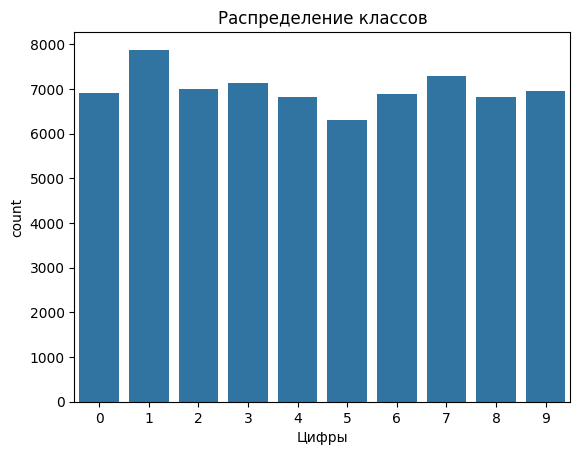

X train shape (49000, 784)
y train shape (49000, 10)
X test shape (21000, 784)
y test shape (21000, 10)


In [100]:
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Для теста
# X, y = reduce_dataset(X, y, 100)

plot_class_distribution(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777)

# Преодбработка
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0], -1)

print("X train shape", X_train.shape)
print("y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)

# Простой 3-х слойный персептрон
### Архитектура
#### Input ► Dense-300 ► Dense-100 ► Output 
* Lr = 0.001
* batch_size = 256
* epochs = 40


### Epoch: 1, time: 0.88s, mean loss: 0.60601110
### Epoch: 2, time: 0.83s, mean loss: 0.21426540
### Epoch: 3, time: 0.88s, mean loss: 0.15817092
### Epoch: 4, time: 0.79s, mean loss: 0.12369787
### Epoch: 5, time: 0.8s, mean loss: 0.10027633
### Epoch: 6, time: 0.81s, mean loss: 0.08368363
### Epoch: 7, time: 0.79s, mean loss: 0.07012895
### Epoch: 8, time: 0.81s, mean loss: 0.06012315
### Epoch: 9, time: 0.8s, mean loss: 0.05125304
### Epoch: 10, time: 0.8s, mean loss: 0.04420283
### Epoch: 11, time: 0.79s, mean loss: 0.03783088
### Epoch: 12, time: 0.79s, mean loss: 0.03287108
### Epoch: 13, time: 0.79s, mean loss: 0.02832638
### Epoch: 14, time: 0.8s, mean loss: 0.02453817
### Epoch: 15, time: 0.79s, mean loss: 0.02178379
### Epoch: 16, time: 0.8s, mean loss: 0.01845059
### Epoch: 17, time: 0.79s, mean loss: 0.01579038
### Epoch: 18, time: 0.8s, mean loss: 0.01367865
### Epoch: 19, time: 0.84s, mean loss: 0.01180632
### Epoch: 20, time: 0.79s, mean loss: 0.01028887
### Epoch: 21, 

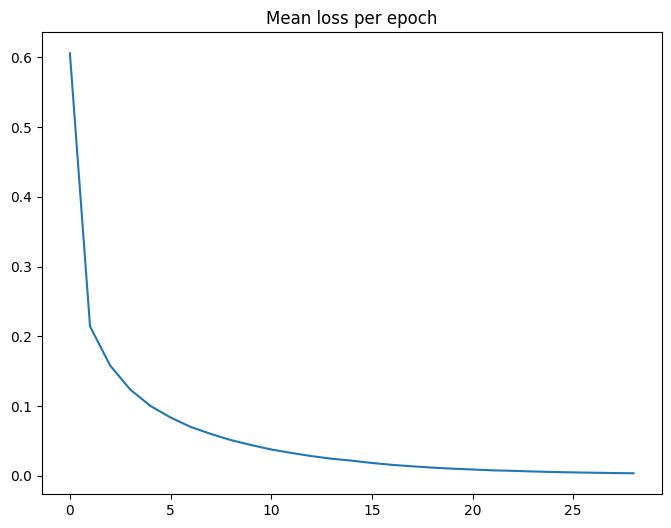

In [112]:
simple_3L_network = NerualNetworkBase(
  [Dense(28*28, 300), ReLU(), Dense(300, 100), ReLU(), Dense(100,10), Softmax()],
  cross_entropy_loss 
) 

simple_3L_network.train(
    X_train,
    y_train,
    batch_size=256,
    learning_rate=0.001,
    epochs=40, print_epoch_loss=True)
simple_3L_network.print_total_time()
simple_3L_network.show_loss()

In [113]:
predictions = simple_3L_network.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9822    0.9896    0.9859      2011
           1     0.9858    0.9892    0.9875      2310
           2     0.9728    0.9757    0.9742      2054
           3     0.9723    0.9753    0.9738      2228
           4     0.9832    0.9804    0.9818      2093
           5     0.9755    0.9642    0.9698      1898
           6     0.9823    0.9823    0.9823      2033
           7     0.9734    0.9818    0.9776      2197
           8     0.9775    0.9687    0.9731      2015
           9     0.9698    0.9658    0.9678      2161

    accuracy                         0.9775     21000
   macro avg     0.9775    0.9773    0.9774     21000
weighted avg     0.9775    0.9775    0.9775     21000



# LeNet 

In [ ]:
X_train = X_train.reshape(-1, 1,28,28)
X_test = X_test.reshape(-1, 1,28,28)

In [81]:
lenet5 = NerualNetworkBase(
    [
        Сonvolution(1, 6, 5, stride=1, padding=2),
        ReLU(),
        MaxPooling(2, 2),
        Сonvolution(6, 16, 5),
        ReLU(),
        MaxPooling(2,2),
        Reshape((-1, 16*5*5)),
        Dense(16*5*5, 120),
        ReLU(),
        Dense(120,84),
        ReLU(),
        Dense(84, 10),
        Softmax()
    ],
    cross_entropy_loss
)

lenet5.train(X_train, y_train, batch_size=256, learning_rate=0.001, epochs=40, print_epoch_loss=True)
lenet5.print_total_time()
lenet5.show_loss()

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch mean loss:  18.68952393641859
Epoch mean loss:  15.147343960245902
Epoch mean loss:  11.345444707517462


KeyboardInterrupt: 

In [ ]:
pred = lenet5.predict(X_test)
predictions = [np.argmax(pred[i]) for i in range(len(pred))]
print(classification_report([np.argmax(y) for y in y_test], predictions, digits=4))

              precision    recall  f1-score   support

           0       0.12      1.00      0.22        25
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        20

    accuracy                           0.12       200
   macro avg       0.01      0.10      0.02       200
weighted avg       0.02      0.12      0.03       200



c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,